Recode用中文注释来帮助理解

In [5]:
import numpy as np

In [6]:
class Node:
    def __init__(self, inputs=[]):
        # 初始化节点属性
        self.inputs = inputs
        self.outputs = []
        
        # 如果节点有inputs，那么该节点就是所有inputs节点的outbound_node
        for n in self.inputs:
            n.outputs.append(self)
        
        self.value = None
        
        self.gradients = {}
        # 字典的key是该节点的inbound_nodes，对应的value是该节点对于input节点的偏导值
        # \partial{node}{input_i}
    
    def forward(self):
        """
        正向传播
        用input的值以及节点值来计算output值并存储在这个节点中
        """
        
        raise NotImplemented
    
    def backward(self):
        
        raise NotImplemented
    
    
class Input(Node):
    def __init__(self):
        """
        Node的子类, Input类没有inbound节点
        """
        Node.__init__(self)
    
    def forward(self, value=None):
        """
        只有Input节点可以传入value给forward方法，其他节点的value都是从各自的input节点里获得的
        但老师给的例子里也没有传入value，而是用Input_node.value来赋值
        """
        if value:
            self.value = value
        # Input_node的值一般为data或者模型的系数
    
    def backward(self):
        self.gradients = {self:0} # gradient在init方法里已经初始化了，这里初始化应该是防止在没有output时调用gradients时出现key error
        for n in self.outputs:
            grad_cost = n.gradients[self] # 反向传播，把output节点的偏导传递到这个节点
            self.gradients[self] = grad_cost * 1 # 该节点的偏导数=output节点偏导数 * 该节点偏导数 (x的导数就是1)

# 这个子类并没有用到
# 功能为在进行forward计算的时候把所有input的值加起来并存储在这个节点中
class Add(Node):
    def __init__(self, *nodes):
        Node.__init__(self, nodes)
        
    def forward(self):
        self.value = sum(map(lambda n: n.value, self.inputs))
        

# 对传入的节点进行线性计算
class Linear(Node):
    def __init__(self, nodes, weights, bias):
        Node.__init__(self, [nodes, weights, bias])
        
    def forward(self):
        inputs = self.inputs[0].value
        weights = self.inputs[1].value
        bias = self.inputs[2].value
        # z=wx+b
        self.value = np.dot(inputs, weights) + bias
    
    def backward(self):
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs} # 初始化gradients
        
        for n in self.outputs:
            # 对z=wx+b分别求偏导数，然后乘以(内积)反向传播过来的偏导
            grad_cost = n.gradients[self]
            
            self.gradients[self.inputs[0]] = np.dot(grad_cost, self.inputs[1].value.T) # w
            self.gradients[self.inputs[1]] = np.dot(self.inputs[0].value.T, grad_cost) # x
            self.gradients[self.inputs[2]] = np.sum(grad_cost, axis=0, keepdims=False) 


class Sigmoid(Node):
    def __init__(self, node):
        Node.__init__(self, [node])
    
    def _sigmoid(self, x):
        return 1./(1 + np.exp(-1 * x)) # 这里 '1.' 和 '1' 没有区别
    
    def forward(self):
        self.x = self.inputs[0].value
        self.value = self._sigmoid(self.x) # sigmoid计算
    
    def backward(self):
        self.partial = self._sigmoid(self.x) * (1 - self._sigmoid(self.x)) # 由于forward方法会比backward先执行，所以self.x已经存在
        
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}
        
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self.inputs[0]] = grad_cost * self.partial # 点乘，保持矩形形状不变
            
        
class MSE(Node):
    def __init__(self, y, a):
        Node.__init__(self, [y, a])
        
    def forward(self):
        y = self.inputs[0].value.reshape(-1, 1)
        a = self.inputs[1].value.reshape(-1, 1)
        assert(y.shape == a.shape)
        
        self.m = self.inputs[0].value.shape[0]  # 行数，也就是y中样本个数
        self.diff = y - a
        
        self.value = np.mean(self.diff ** 2) # Loss
        
    def backward(self):
        self.gradients[self.inputs[0]] = (2 / self.m) * self.diff
        self.gradients[self.inputs[1]] = (-2 / self.m) * self.diff
        
        
def forward_and_backward(outputnode, graph):
    # 按已经排序好的节点执行forward和backward(倒序)方法
    for n in graph:
        n.forward()
    for n in graph[::-1]:
        n.backward()
        
    
def topological_sort(feed_dict):
    """
    对节点进行topological排序
    """
    input_nodes = [n for n in feed_dict.keys()]
    
    # 对所有节点计算in和out节点
    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in': set(), 'out': set()}
        
        for m in n.outputs:
            if m not in G:
                G[m] = {'in': set(), 'out': set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)
    
    # 对所有节点进行topological排序 -> 代码逻辑：当一个节点没有input时，可以加入排序队列；当一个节点进入list后，删除其他节点和该节点的关系
    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()
        
        if isinstance(n, Input):
            n.value = feed_dict[n]
            # 在排序的时候对input_nodes进行赋值
        
        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            
            if len(G[m]['in']) == 0:
                S.add(m)
    return L

def sgd_update(trainables, learning_rate=1e-2):
    # 用sgd方法对可训练的参数进行优化
    for t in trainables:
        t.value += -1 * learning_rate * t.gradients[t]

In [7]:
import numpy as np
from sklearn.datasets import load_boston
from sklearn.utils import shuffle, resample

In [8]:
# 加载数据
data = load_boston()
X_ = data['data']
y_ = data['target']
losses = []

In [9]:
# 数据处理
# 归一化
X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)

n_features = X_.shape[1]
n_hidden = 10
# w不为0，b可以为0
W1_ = np.random.randn(n_features, n_hidden)
b1_ = np.zeros(n_hidden)
W2_ = np.random.randn(n_hidden, 1)
b2_ = np.zeros(1)

In [10]:
# 搭建神经网络
X, y = Input(), Input()
W1, b1 = Input(), Input()
W2, b2 = Input(), Input()

l1 = Linear(X, W1, b1)
s1 = Sigmoid(l1)
l2 = Linear(s1, W2, b2)
cost = MSE(y, l2)

feed_dict = {
    X: X_,
    y: y_,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_
}

epochs = 5000 # 迭代次数
m = X_.shape[0]
batch_size = 16 
steps_per_epoch = m // batch_size

graph = topological_sort(feed_dict)
trainables = [W1, b1, W2, b2]

In [11]:
# 训练
print("Total numer of examples = {}".format(m))

# step 4
for i in range(epochs):
    loss = 0
    for j in range(steps_per_epoch):
        # Step1 随机取一组数据
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)
        
        # 将新取的数据赋值给X，y Inputs
        X.value = X_batch
        y.value = y_batch
        # Step2 forward and backward
        _ = None
        forward_and_backward(_, graph) # 只需要运行，不需要输出
        
        # Step3 梯度下降
        rate = 1e-2
        sgd_update(trainables, rate)
        loss += graph[-1].value #loss累加
    
    if i % 100 == 0:
        print("Epoch: {}, loss: {:.3f}".format(i+1, loss/steps_per_epoch))
        losses.append(loss)

Total numer of examples = 506
Epoch: 1, loss: 179.568
Epoch: 101, loss: 5.929
Epoch: 201, loss: 6.608
Epoch: 301, loss: 5.905
Epoch: 401, loss: 5.301
Epoch: 501, loss: 4.790
Epoch: 601, loss: 4.171
Epoch: 701, loss: 3.727
Epoch: 801, loss: 3.921
Epoch: 901, loss: 4.159
Epoch: 1001, loss: 4.025
Epoch: 1101, loss: 3.706
Epoch: 1201, loss: 3.972
Epoch: 1301, loss: 3.913
Epoch: 1401, loss: 3.241
Epoch: 1501, loss: 3.801
Epoch: 1601, loss: 3.607
Epoch: 1701, loss: 3.455
Epoch: 1801, loss: 3.429
Epoch: 1901, loss: 3.793
Epoch: 2001, loss: 3.275
Epoch: 2101, loss: 3.514
Epoch: 2201, loss: 3.314
Epoch: 2301, loss: 3.184
Epoch: 2401, loss: 2.967
Epoch: 2501, loss: 4.081
Epoch: 2601, loss: 3.327
Epoch: 2701, loss: 3.365
Epoch: 2801, loss: 3.058
Epoch: 2901, loss: 3.853
Epoch: 3001, loss: 3.037
Epoch: 3101, loss: 3.533
Epoch: 3201, loss: 3.185
Epoch: 3301, loss: 3.770
Epoch: 3401, loss: 3.210
Epoch: 3501, loss: 3.874
Epoch: 3601, loss: 3.570
Epoch: 3701, loss: 3.574
Epoch: 3801, loss: 3.228
Epoch

In [12]:
import matplotlib.pyplot as plt

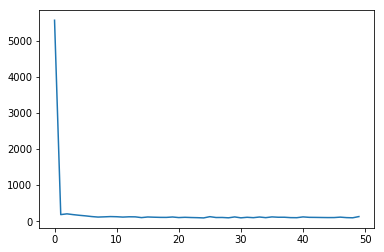

In [13]:
plt.plot(range(len(losses)), losses)

In [14]:
W2.value

array([[ 5.11325748],
       [11.19127699],
       [11.5069862 ],
       [ 4.25251133],
       [ 7.41449821],
       [ 8.99149016],
       [ 9.78188094],
       [ 4.58386922],
       [ 7.46368908],
       [ 5.51801126]])

In [15]:
import keras

In [16]:
from keras.layers import Dense
from keras.models import Sequential

model = Sequential()

model.add(Dense(units=64, activation='sigmoid', input_dim=13))
model.add(Dense(units=30, activation='sigmoid', input_dim=64))
model.add(Dense(units=1))

model.compile(loss='mse', optimizer='sgd', metrics=['mse'])

In [ ]:
model.fit(X_, y_, epochs=5000, batch_size=32)

Epoch 1/5000
506/506 [==============================] - 0s 966us/step - loss: 148.4776 - mse: 148.4776
Epoch 2/5000
506/506 [==============================] - 0s 87us/step - loss: 68.7669 - mse: 68.7669
Epoch 3/5000
506/506 [==============================] - 0s 88us/step - loss: 50.6320 - mse: 50.6320
Epoch 4/5000
506/506 [==============================] - 0s 70us/step - loss: 39.7743 - mse: 39.7743
Epoch 5/5000
506/506 [==============================] - 0s 66us/step - loss: 32.2275 - mse: 32.2275
Epoch 6/5000
506/506 [==============================] - 0s 63us/step - loss: 28.0231 - mse: 28.0231
Epoch 7/5000
506/506 [==============================] - 0s 80us/step - loss: 25.6700 - mse: 25.6700
Epoch 8/5000
506/506 [==============================] - 0s 81us/step - loss: 24.6936 - mse: 24.6936
Epoch 9/5000
506/506 [==============================] - 0s 64us/step - loss: 21.9459 - mse: 21.9459
Epoch 10/5000
506/506 [==============================] - 0s 62us/step - loss: 21.5913 - mse: 21.5

506/506 [==============================] - 0s 78us/step - loss: 9.3632 - mse: 9.3632
Epoch 83/5000
506/506 [==============================] - 0s 86us/step - loss: 9.4576 - mse: 9.4576
Epoch 84/5000
506/506 [==============================] - 0s 77us/step - loss: 9.2144 - mse: 9.2144
Epoch 85/5000
506/506 [==============================] - 0s 73us/step - loss: 9.1517 - mse: 9.1517
Epoch 86/5000
506/506 [==============================] - 0s 73us/step - loss: 9.1948 - mse: 9.1948
Epoch 87/5000
506/506 [==============================] - 0s 100us/step - loss: 8.8936 - mse: 8.8936
Epoch 88/5000
506/506 [==============================] - 0s 105us/step - loss: 9.1021 - mse: 9.1021
Epoch 89/5000
506/506 [==============================] - 0s 94us/step - loss: 9.0197 - mse: 9.0197
Epoch 90/5000
506/506 [==============================] - 0s 79us/step - loss: 8.9091 - mse: 8.9091
Epoch 91/5000
506/506 [==============================] - 0s 81us/step - loss: 9.3561 - mse: 9.3561
Epoch 92/5000
506/506 

506/506 [==============================] - 0s 77us/step - loss: 6.3760 - mse: 6.3760
Epoch 165/5000
506/506 [==============================] - 0s 82us/step - loss: 5.9262 - mse: 5.9262
Epoch 166/5000
506/506 [==============================] - 0s 68us/step - loss: 5.9028 - mse: 5.9028
Epoch 167/5000
506/506 [==============================] - 0s 85us/step - loss: 5.8595 - mse: 5.8595
Epoch 168/5000
506/506 [==============================] - 0s 79us/step - loss: 5.8832 - mse: 5.8832
Epoch 169/5000
506/506 [==============================] - 0s 114us/step - loss: 5.7707 - mse: 5.7707
Epoch 170/5000
506/506 [==============================] - 0s 107us/step - loss: 5.9084 - mse: 5.9084
Epoch 171/5000
506/506 [==============================] - 0s 97us/step - loss: 5.6286 - mse: 5.6286
Epoch 172/5000
506/506 [==============================] - 0s 148us/step - loss: 5.9455 - mse: 5.9455
Epoch 173/5000
506/506 [==============================] - 0s 84us/step - loss: 5.7565 - mse: 5.7565
Epoch 174/50

Epoch 246/5000
506/506 [==============================] - 0s 80us/step - loss: 4.5901 - mse: 4.5901
Epoch 247/5000
506/506 [==============================] - 0s 71us/step - loss: 4.5854 - mse: 4.5854
Epoch 248/5000
506/506 [==============================] - 0s 65us/step - loss: 4.6736 - mse: 4.6736
Epoch 249/5000
506/506 [==============================] - 0s 72us/step - loss: 4.6645 - mse: 4.6645
Epoch 250/5000
506/506 [==============================] - 0s 59us/step - loss: 4.6297 - mse: 4.6297
Epoch 251/5000
506/506 [==============================] - 0s 68us/step - loss: 4.6155 - mse: 4.6155
Epoch 252/5000
506/506 [==============================] - 0s 66us/step - loss: 4.5548 - mse: 4.5548
Epoch 253/5000
506/506 [==============================] - 0s 67us/step - loss: 4.5274 - mse: 4.5274
Epoch 254/5000
506/506 [==============================] - 0s 66us/step - loss: 4.4446 - mse: 4.4446
Epoch 255/5000
506/506 [==============================] - 0s 61us/step - loss: 4.5895 - mse: 4.5895


506/506 [==============================] - 0s 96us/step - loss: 3.9914 - mse: 3.9914
Epoch 328/5000
506/506 [==============================] - 0s 84us/step - loss: 3.8985 - mse: 3.8985
Epoch 329/5000
506/506 [==============================] - 0s 86us/step - loss: 3.8485 - mse: 3.8485
Epoch 330/5000
506/506 [==============================] - 0s 62us/step - loss: 3.7277 - mse: 3.7277
Epoch 331/5000
506/506 [==============================] - 0s 66us/step - loss: 3.7165 - mse: 3.7165
Epoch 332/5000
506/506 [==============================] - 0s 62us/step - loss: 3.6909 - mse: 3.6909
Epoch 333/5000
506/506 [==============================] - 0s 64us/step - loss: 3.8015 - mse: 3.8015
Epoch 334/5000
506/506 [==============================] - 0s 62us/step - loss: 3.7128 - mse: 3.7128
Epoch 335/5000
506/506 [==============================] - 0s 56us/step - loss: 3.9236 - mse: 3.9236
Epoch 336/5000
506/506 [==============================] - 0s 70us/step - loss: 3.9365 - mse: 3.9365
Epoch 337/5000


506/506 [==============================] - 0s 80us/step - loss: 3.1709 - mse: 3.1709
Epoch 409/5000
506/506 [==============================] - 0s 129us/step - loss: 3.0798 - mse: 3.0798
Epoch 410/5000
506/506 [==============================] - 0s 80us/step - loss: 3.1613 - mse: 3.1613
Epoch 411/5000
506/506 [==============================] - 0s 66us/step - loss: 3.0941 - mse: 3.0941
Epoch 412/5000
506/506 [==============================] - 0s 86us/step - loss: 3.1046 - mse: 3.1046
Epoch 413/5000
506/506 [==============================] - 0s 78us/step - loss: 3.1381 - mse: 3.1381
Epoch 414/5000
506/506 [==============================] - 0s 82us/step - loss: 3.2868 - mse: 3.2868
Epoch 415/5000
506/506 [==============================] - 0s 101us/step - loss: 3.1210 - mse: 3.1210
Epoch 416/5000
506/506 [==============================] - 0s 104us/step - loss: 3.1292 - mse: 3.1292
Epoch 417/5000
506/506 [==============================] - 0s 98us/step - loss: 3.3897 - mse: 3.3897
Epoch 418/50

506/506 [==============================] - 0s 61us/step - loss: 2.7810 - mse: 2.7810
Epoch 491/5000
506/506 [==============================] - 0s 71us/step - loss: 2.8094 - mse: 2.8094
Epoch 492/5000
506/506 [==============================] - 0s 67us/step - loss: 2.7919 - mse: 2.7919
Epoch 493/5000
506/506 [==============================] - 0s 61us/step - loss: 2.8523 - mse: 2.8523
Epoch 494/5000
506/506 [==============================] - 0s 61us/step - loss: 2.9603 - mse: 2.9603
Epoch 495/5000
506/506 [==============================] - 0s 83us/step - loss: 2.7413 - mse: 2.7413
Epoch 496/5000
506/506 [==============================] - 0s 71us/step - loss: 2.7054 - mse: 2.7054
Epoch 497/5000
506/506 [==============================] - 0s 75us/step - loss: 2.7233 - mse: 2.7233
Epoch 498/5000
506/506 [==============================] - 0s 58us/step - loss: 2.7094 - mse: 2.7094
Epoch 499/5000
506/506 [==============================] - 0s 55us/step - loss: 2.7912 - mse: 2.7912
Epoch 500/5000


506/506 [==============================] - 0s 57us/step - loss: 2.4298 - mse: 2.4298
Epoch 573/5000
506/506 [==============================] - 0s 63us/step - loss: 2.5562 - mse: 2.5562
Epoch 574/5000
506/506 [==============================] - 0s 62us/step - loss: 2.5570 - mse: 2.5570
Epoch 575/5000
506/506 [==============================] - 0s 58us/step - loss: 2.5148 - mse: 2.5148
Epoch 576/5000
506/506 [==============================] - 0s 60us/step - loss: 2.3835 - mse: 2.3835
Epoch 577/5000
506/506 [==============================] - 0s 65us/step - loss: 2.5280 - mse: 2.5280
Epoch 578/5000
506/506 [==============================] - 0s 65us/step - loss: 2.4043 - mse: 2.4043
Epoch 579/5000
506/506 [==============================] - 0s 61us/step - loss: 2.4442 - mse: 2.4442
Epoch 580/5000
506/506 [==============================] - 0s 65us/step - loss: 2.4572 - mse: 2.4572
Epoch 581/5000
506/506 [==============================] - 0s 78us/step - loss: 2.5036 - mse: 2.5036
Epoch 582/5000


506/506 [==============================] - 0s 80us/step - loss: 2.3433 - mse: 2.3433
Epoch 655/5000
506/506 [==============================] - 0s 72us/step - loss: 2.2895 - mse: 2.2895
Epoch 656/5000
506/506 [==============================] - 0s 85us/step - loss: 2.2541 - mse: 2.2541
Epoch 657/5000
506/506 [==============================] - 0s 103us/step - loss: 2.1862 - mse: 2.1862
Epoch 658/5000
506/506 [==============================] - 0s 99us/step - loss: 2.2495 - mse: 2.2495
Epoch 659/5000
506/506 [==============================] - 0s 104us/step - loss: 2.2641 - mse: 2.2641
Epoch 660/5000
506/506 [==============================] - 0s 76us/step - loss: 2.2561 - mse: 2.2561
Epoch 661/5000
506/506 [==============================] - 0s 70us/step - loss: 2.2483 - mse: 2.2483
Epoch 662/5000
506/506 [==============================] - 0s 76us/step - loss: 2.2922 - mse: 2.2922
Epoch 663/5000
506/506 [==============================] - 0s 65us/step - loss: 2.2893 - mse: 2.2893
Epoch 664/500

506/506 [==============================] - 0s 97us/step - loss: 2.0990 - mse: 2.0990
Epoch 737/5000
506/506 [==============================] - 0s 59us/step - loss: 2.1201 - mse: 2.1201
Epoch 738/5000
506/506 [==============================] - 0s 61us/step - loss: 2.1341 - mse: 2.1341
Epoch 739/5000
506/506 [==============================] - 0s 74us/step - loss: 2.2156 - mse: 2.2156
Epoch 740/5000
506/506 [==============================] - 0s 67us/step - loss: 2.0523 - mse: 2.0523
Epoch 741/5000
506/506 [==============================] - 0s 69us/step - loss: 2.1000 - mse: 2.1000
Epoch 742/5000
506/506 [==============================] - 0s 68us/step - loss: 2.0873 - mse: 2.0873
Epoch 743/5000
506/506 [==============================] - 0s 70us/step - loss: 2.0463 - mse: 2.0463
Epoch 744/5000
506/506 [==============================] - 0s 57us/step - loss: 2.1289 - mse: 2.1289
Epoch 745/5000
506/506 [==============================] - 0s 60us/step - loss: 2.0373 - mse: 2.0373
Epoch 746/5000


506/506 [==============================] - 0s 63us/step - loss: 1.9876 - mse: 1.9876
Epoch 819/5000
506/506 [==============================] - 0s 65us/step - loss: 1.9473 - mse: 1.9473
Epoch 820/5000
506/506 [==============================] - 0s 59us/step - loss: 1.9401 - mse: 1.9401
Epoch 821/5000
506/506 [==============================] - 0s 59us/step - loss: 1.9833 - mse: 1.9833
Epoch 822/5000
506/506 [==============================] - 0s 62us/step - loss: 1.9660 - mse: 1.9660
Epoch 823/5000
506/506 [==============================] - 0s 54us/step - loss: 1.9879 - mse: 1.9879
Epoch 824/5000
506/506 [==============================] - 0s 54us/step - loss: 2.0086 - mse: 2.0086
Epoch 825/5000
506/506 [==============================] - 0s 56us/step - loss: 1.9087 - mse: 1.9087
Epoch 826/5000
506/506 [==============================] - 0s 60us/step - loss: 1.9499 - mse: 1.9499
Epoch 827/5000
506/506 [==============================] - 0s 66us/step - loss: 2.0656 - mse: 2.0656
Epoch 828/5000


506/506 [==============================] - 0s 63us/step - loss: 1.7966 - mse: 1.7966
Epoch 901/5000
506/506 [==============================] - 0s 56us/step - loss: 1.7745 - mse: 1.7745
Epoch 902/5000
506/506 [==============================] - 0s 58us/step - loss: 1.7864 - mse: 1.7864
Epoch 903/5000
506/506 [==============================] - 0s 64us/step - loss: 1.7754 - mse: 1.7754
Epoch 904/5000
506/506 [==============================] - 0s 67us/step - loss: 1.8250 - mse: 1.8250
Epoch 905/5000
506/506 [==============================] - 0s 58us/step - loss: 1.8588 - mse: 1.8588
Epoch 906/5000
506/506 [==============================] - 0s 58us/step - loss: 1.8885 - mse: 1.8885
Epoch 907/5000
506/506 [==============================] - 0s 60us/step - loss: 1.7733 - mse: 1.7733
Epoch 908/5000
506/506 [==============================] - 0s 54us/step - loss: 1.7668 - mse: 1.7668
Epoch 909/5000
506/506 [==============================] - 0s 60us/step - loss: 1.8048 - mse: 1.8048
Epoch 910/5000


506/506 [==============================] - 0s 64us/step - loss: 1.6914 - mse: 1.6914
Epoch 983/5000
506/506 [==============================] - 0s 57us/step - loss: 1.7043 - mse: 1.7043
Epoch 984/5000
506/506 [==============================] - 0s 53us/step - loss: 1.7383 - mse: 1.7383
Epoch 985/5000
506/506 [==============================] - 0s 59us/step - loss: 1.6843 - mse: 1.6843
Epoch 986/5000
506/506 [==============================] - 0s 64us/step - loss: 1.7013 - mse: 1.7013
Epoch 987/5000
506/506 [==============================] - 0s 60us/step - loss: 1.6773 - mse: 1.6773
Epoch 988/5000
506/506 [==============================] - 0s 62us/step - loss: 1.6652 - mse: 1.6652
Epoch 989/5000
506/506 [==============================] - 0s 56us/step - loss: 1.7342 - mse: 1.7342
Epoch 990/5000
506/506 [==============================] - 0s 63us/step - loss: 1.7211 - mse: 1.7211
Epoch 991/5000
506/506 [==============================] - 0s 56us/step - loss: 1.6927 - mse: 1.6927
Epoch 992/5000


506/506 [==============================] - 0s 95us/step - loss: 1.5901 - mse: 1.5901
Epoch 1064/5000
506/506 [==============================] - 0s 100us/step - loss: 1.6321 - mse: 1.6321
Epoch 1065/5000
506/506 [==============================] - 0s 82us/step - loss: 1.5327 - mse: 1.5327
Epoch 1066/5000
506/506 [==============================] - 0s 88us/step - loss: 1.6322 - mse: 1.6322
Epoch 1067/5000
506/506 [==============================] - 0s 82us/step - loss: 1.5867 - mse: 1.5867
Epoch 1068/5000
506/506 [==============================] - 0s 70us/step - loss: 1.6199 - mse: 1.6199
Epoch 1069/5000
506/506 [==============================] - 0s 69us/step - loss: 1.5453 - mse: 1.5453
Epoch 1070/5000
506/506 [==============================] - 0s 75us/step - loss: 1.5975 - mse: 1.5975
Epoch 1071/5000
506/506 [==============================] - 0s 71us/step - loss: 1.5410 - mse: 1.5410
Epoch 1072/5000
506/506 [==============================] - 0s 69us/step - loss: 1.5397 - mse: 1.5397
Epoch

506/506 [==============================] - 0s 69us/step - loss: 1.4877 - mse: 1.4877
Epoch 1145/5000
506/506 [==============================] - 0s 61us/step - loss: 1.4926 - mse: 1.4926
Epoch 1146/5000
506/506 [==============================] - 0s 54us/step - loss: 1.4786 - mse: 1.4786
Epoch 1147/5000
506/506 [==============================] - 0s 60us/step - loss: 1.4413 - mse: 1.4413
Epoch 1148/5000
506/506 [==============================] - 0s 59us/step - loss: 1.4612 - mse: 1.4612
Epoch 1149/5000
506/506 [==============================] - 0s 60us/step - loss: 1.5065 - mse: 1.5065
Epoch 1150/5000
506/506 [==============================] - 0s 64us/step - loss: 1.4464 - mse: 1.4464
Epoch 1151/5000
506/506 [==============================] - 0s 60us/step - loss: 1.5026 - mse: 1.5026
Epoch 1152/5000
506/506 [==============================] - 0s 60us/step - loss: 1.4921 - mse: 1.4921
Epoch 1153/5000
506/506 [==============================] - 0s 66us/step - loss: 1.5256 - mse: 1.5256
Epoch 

506/506 [==============================] - 0s 61us/step - loss: 1.3626 - mse: 1.3626
Epoch 1226/5000
506/506 [==============================] - 0s 62us/step - loss: 1.3193 - mse: 1.3193
Epoch 1227/5000
506/506 [==============================] - 0s 66us/step - loss: 1.3838 - mse: 1.3838
Epoch 1228/5000
506/506 [==============================] - 0s 67us/step - loss: 1.3535 - mse: 1.3535
Epoch 1229/5000
506/506 [==============================] - 0s 62us/step - loss: 1.4137 - mse: 1.4137
Epoch 1230/5000
506/506 [==============================] - 0s 56us/step - loss: 1.3417 - mse: 1.3417
Epoch 1231/5000
506/506 [==============================] - 0s 59us/step - loss: 1.3446 - mse: 1.3446
Epoch 1232/5000
506/506 [==============================] - 0s 62us/step - loss: 1.3612 - mse: 1.3612
Epoch 1233/5000
506/506 [==============================] - 0s 66us/step - loss: 1.4120 - mse: 1.4120
Epoch 1234/5000
506/506 [==============================] - 0s 60us/step - loss: 1.3239 - mse: 1.3239
Epoch 

506/506 [==============================] - 0s 61us/step - loss: 1.2763 - mse: 1.2763
Epoch 1307/5000
506/506 [==============================] - 0s 61us/step - loss: 1.2566 - mse: 1.2566
Epoch 1308/5000
506/506 [==============================] - 0s 58us/step - loss: 1.2345 - mse: 1.2345
Epoch 1309/5000
506/506 [==============================] - 0s 58us/step - loss: 1.2581 - mse: 1.2581
Epoch 1310/5000
506/506 [==============================] - 0s 63us/step - loss: 1.2708 - mse: 1.2708
Epoch 1311/5000
506/506 [==============================] - 0s 58us/step - loss: 1.2504 - mse: 1.2504
Epoch 1312/5000
506/506 [==============================] - 0s 67us/step - loss: 1.2861 - mse: 1.2861
Epoch 1313/5000
506/506 [==============================] - 0s 63us/step - loss: 1.2879 - mse: 1.2879
Epoch 1314/5000
506/506 [==============================] - 0s 57us/step - loss: 1.1905 - mse: 1.1905
Epoch 1315/5000
506/506 [==============================] - 0s 60us/step - loss: 1.2885 - mse: 1.2885
Epoch 

506/506 [==============================] - 0s 58us/step - loss: 1.1774 - mse: 1.1774
Epoch 1388/5000
506/506 [==============================] - 0s 57us/step - loss: 1.1153 - mse: 1.1153
Epoch 1389/5000
506/506 [==============================] - 0s 55us/step - loss: 1.1380 - mse: 1.1380
Epoch 1390/5000
506/506 [==============================] - 0s 58us/step - loss: 1.1719 - mse: 1.1719
Epoch 1391/5000
506/506 [==============================] - 0s 63us/step - loss: 1.1828 - mse: 1.1828
Epoch 1392/5000
506/506 [==============================] - 0s 63us/step - loss: 1.1445 - mse: 1.1445
Epoch 1393/5000
506/506 [==============================] - 0s 60us/step - loss: 1.1534 - mse: 1.1534
Epoch 1394/5000
506/506 [==============================] - 0s 60us/step - loss: 1.1409 - mse: 1.1409
Epoch 1395/5000
506/506 [==============================] - 0s 66us/step - loss: 1.1752 - mse: 1.1752
Epoch 1396/5000
506/506 [==============================] - 0s 67us/step - loss: 1.1583 - mse: 1.1583
Epoch 

506/506 [==============================] - 0s 79us/step - loss: 1.0870 - mse: 1.0870
Epoch 1469/5000
506/506 [==============================] - 0s 60us/step - loss: 1.1164 - mse: 1.1164
Epoch 1470/5000
506/506 [==============================] - 0s 60us/step - loss: 1.1068 - mse: 1.1068
Epoch 1471/5000
506/506 [==============================] - 0s 61us/step - loss: 1.1059 - mse: 1.1059
Epoch 1472/5000
506/506 [==============================] - 0s 59us/step - loss: 1.0409 - mse: 1.0409
Epoch 1473/5000
506/506 [==============================] - 0s 60us/step - loss: 1.0486 - mse: 1.0486
Epoch 1474/5000
506/506 [==============================] - 0s 62us/step - loss: 1.1348 - mse: 1.1348
Epoch 1475/5000
506/506 [==============================] - 0s 58us/step - loss: 1.0799 - mse: 1.0799
Epoch 1476/5000
506/506 [==============================] - 0s 55us/step - loss: 1.0851 - mse: 1.0851
Epoch 1477/5000
506/506 [==============================] - 0s 58us/step - loss: 1.0193 - mse: 1.0193
Epoch 

506/506 [==============================] - 0s 63us/step - loss: 0.9856 - mse: 0.9856
Epoch 1550/5000
506/506 [==============================] - 0s 59us/step - loss: 1.0065 - mse: 1.0065
Epoch 1551/5000
506/506 [==============================] - 0s 61us/step - loss: 1.0036 - mse: 1.0036
Epoch 1552/5000
506/506 [==============================] - 0s 94us/step - loss: 0.9781 - mse: 0.9781
Epoch 1553/5000
506/506 [==============================] - 0s 69us/step - loss: 0.9994 - mse: 0.9994
Epoch 1554/5000
506/506 [==============================] - 0s 72us/step - loss: 0.9754 - mse: 0.9754
Epoch 1555/5000
506/506 [==============================] - 0s 57us/step - loss: 1.0533 - mse: 1.0533
Epoch 1556/5000
506/506 [==============================] - 0s 61us/step - loss: 1.0428 - mse: 1.0428
Epoch 1557/5000
506/506 [==============================] - 0s 57us/step - loss: 0.9904 - mse: 0.9904
Epoch 1558/5000
506/506 [==============================] - 0s 62us/step - loss: 1.0079 - mse: 1.0079
Epoch 

506/506 [==============================] - 0s 71us/step - loss: 0.9785 - mse: 0.9785
Epoch 1631/5000
506/506 [==============================] - 0s 76us/step - loss: 0.9400 - mse: 0.9400
Epoch 1632/5000
506/506 [==============================] - 0s 68us/step - loss: 0.9279 - mse: 0.9279
Epoch 1633/5000
506/506 [==============================] - 0s 67us/step - loss: 0.9925 - mse: 0.9925
Epoch 1634/5000
506/506 [==============================] - 0s 86us/step - loss: 0.9368 - mse: 0.9368
Epoch 1635/5000
506/506 [==============================] - 0s 109us/step - loss: 0.9828 - mse: 0.9828
Epoch 1636/5000
506/506 [==============================] - 0s 94us/step - loss: 0.9860 - mse: 0.9860
Epoch 1637/5000
506/506 [==============================] - 0s 139us/step - loss: 0.9396 - mse: 0.9396
Epoch 1638/5000
506/506 [==============================] - 0s 72us/step - loss: 0.9502 - mse: 0.9502
Epoch 1639/5000
506/506 [==============================] - 0s 68us/step - loss: 0.9447 - mse: 0.9447
Epoc

506/506 [==============================] - 0s 82us/step - loss: 0.8830 - mse: 0.8830
Epoch 1712/5000
506/506 [==============================] - 0s 62us/step - loss: 0.9140 - mse: 0.9140
Epoch 1713/5000
506/506 [==============================] - 0s 58us/step - loss: 0.8976 - mse: 0.8976
Epoch 1714/5000
506/506 [==============================] - 0s 60us/step - loss: 0.8987 - mse: 0.8987
Epoch 1715/5000
506/506 [==============================] - 0s 60us/step - loss: 0.9176 - mse: 0.9176
Epoch 1716/5000
506/506 [==============================] - 0s 79us/step - loss: 0.9085 - mse: 0.9085
Epoch 1717/5000
506/506 [==============================] - 0s 81us/step - loss: 0.9011 - mse: 0.9011
Epoch 1718/5000
506/506 [==============================] - 0s 80us/step - loss: 0.8762 - mse: 0.8762
Epoch 1719/5000
506/506 [==============================] - 0s 79us/step - loss: 0.8622 - mse: 0.8622
Epoch 1720/5000
506/506 [==============================] - 0s 79us/step - loss: 0.8943 - mse: 0.8943
Epoch 

506/506 [==============================] - 0s 76us/step - loss: 0.8056 - mse: 0.8056
Epoch 1793/5000
506/506 [==============================] - 0s 101us/step - loss: 0.8622 - mse: 0.8622
Epoch 1794/5000
506/506 [==============================] - 0s 77us/step - loss: 0.8047 - mse: 0.8047
Epoch 1795/5000
506/506 [==============================] - 0s 97us/step - loss: 0.8339 - mse: 0.8339
Epoch 1796/5000
506/506 [==============================] - 0s 92us/step - loss: 0.8383 - mse: 0.8383
Epoch 1797/5000
506/506 [==============================] - 0s 67us/step - loss: 0.8392 - mse: 0.8392
Epoch 1798/5000
506/506 [==============================] - 0s 76us/step - loss: 0.8158 - mse: 0.8158
Epoch 1799/5000
506/506 [==============================] - 0s 76us/step - loss: 0.8296 - mse: 0.8296
Epoch 1800/5000
506/506 [==============================] - 0s 79us/step - loss: 0.8317 - mse: 0.8317
Epoch 1801/5000
506/506 [==============================] - 0s 62us/step - loss: 0.8425 - mse: 0.8425
Epoch

506/506 [==============================] - 0s 74us/step - loss: 0.7639 - mse: 0.7639
Epoch 1874/5000
506/506 [==============================] - 0s 75us/step - loss: 0.7893 - mse: 0.7893
Epoch 1875/5000
506/506 [==============================] - 0s 61us/step - loss: 0.8121 - mse: 0.8121
Epoch 1876/5000
506/506 [==============================] - 0s 62us/step - loss: 0.7622 - mse: 0.7622
Epoch 1877/5000
506/506 [==============================] - 0s 58us/step - loss: 0.8585 - mse: 0.8585
Epoch 1878/5000
506/506 [==============================] - 0s 59us/step - loss: 0.7715 - mse: 0.7715
Epoch 1879/5000
506/506 [==============================] - 0s 58us/step - loss: 0.7916 - mse: 0.7916
Epoch 1880/5000
506/506 [==============================] - 0s 63us/step - loss: 0.7530 - mse: 0.7530
Epoch 1881/5000
506/506 [==============================] - 0s 60us/step - loss: 0.7924 - mse: 0.7924
Epoch 1882/5000
506/506 [==============================] - 0s 59us/step - loss: 0.8137 - mse: 0.8137
Epoch 

506/506 [==============================] - 0s 67us/step - loss: 0.7325 - mse: 0.7325
Epoch 1955/5000
506/506 [==============================] - 0s 64us/step - loss: 0.7629 - mse: 0.7629
Epoch 1956/5000
506/506 [==============================] - 0s 60us/step - loss: 0.7156 - mse: 0.7156
Epoch 1957/5000
506/506 [==============================] - 0s 62us/step - loss: 0.7480 - mse: 0.7480
Epoch 1958/5000
506/506 [==============================] - 0s 84us/step - loss: 0.7065 - mse: 0.7065
Epoch 1959/5000
506/506 [==============================] - 0s 162us/step - loss: 0.7682 - mse: 0.7682
Epoch 1960/5000
506/506 [==============================] - 0s 108us/step - loss: 0.7244 - mse: 0.7244
Epoch 1961/5000
506/506 [==============================] - 0s 94us/step - loss: 0.7381 - mse: 0.7381
Epoch 1962/5000
506/506 [==============================] - 0s 80us/step - loss: 0.7408 - mse: 0.7408
Epoch 1963/5000
506/506 [==============================] - 0s 85us/step - loss: 0.7335 - mse: 0.7335
Epoc

506/506 [==============================] - 0s 97us/step - loss: 0.6834 - mse: 0.6834
Epoch 2036/5000
506/506 [==============================] - 0s 68us/step - loss: 0.7023 - mse: 0.7023
Epoch 2037/5000
506/506 [==============================] - 0s 74us/step - loss: 0.6839 - mse: 0.6839
Epoch 2038/5000
506/506 [==============================] - 0s 66us/step - loss: 0.6999 - mse: 0.6999
Epoch 2039/5000
506/506 [==============================] - 0s 62us/step - loss: 0.7186 - mse: 0.7186
Epoch 2040/5000
506/506 [==============================] - 0s 64us/step - loss: 0.6924 - mse: 0.6924
Epoch 2041/5000
506/506 [==============================] - 0s 59us/step - loss: 0.6942 - mse: 0.6942
Epoch 2042/5000
506/506 [==============================] - 0s 63us/step - loss: 0.7037 - mse: 0.7037
Epoch 2043/5000
506/506 [==============================] - 0s 63us/step - loss: 0.6940 - mse: 0.6940
Epoch 2044/5000
506/506 [==============================] - 0s 57us/step - loss: 0.6757 - mse: 0.6757
Epoch 

506/506 [==============================] - 0s 91us/step - loss: 0.6407 - mse: 0.6407
Epoch 2117/5000
506/506 [==============================] - 0s 92us/step - loss: 0.6888 - mse: 0.6888
Epoch 2118/5000
506/506 [==============================] - 0s 71us/step - loss: 0.6911 - mse: 0.6911
Epoch 2119/5000
506/506 [==============================] - 0s 75us/step - loss: 0.6742 - mse: 0.6742
Epoch 2120/5000
506/506 [==============================] - 0s 72us/step - loss: 0.6517 - mse: 0.6517
Epoch 2121/5000
506/506 [==============================] - 0s 69us/step - loss: 0.6347 - mse: 0.6347
Epoch 2122/5000
506/506 [==============================] - 0s 84us/step - loss: 0.6551 - mse: 0.6551
Epoch 2123/5000
506/506 [==============================] - 0s 127us/step - loss: 0.6636 - mse: 0.6636
Epoch 2124/5000
506/506 [==============================] - 0s 93us/step - loss: 0.6605 - mse: 0.6605
Epoch 2125/5000
506/506 [==============================] - 0s 137us/step - loss: 0.6609 - mse: 0.6609
Epoc

506/506 [==============================] - 0s 56us/step - loss: 0.6158 - mse: 0.6158
Epoch 2198/5000
506/506 [==============================] - 0s 63us/step - loss: 0.6172 - mse: 0.6172
Epoch 2199/5000
506/506 [==============================] - 0s 62us/step - loss: 0.6068 - mse: 0.6068
Epoch 2200/5000
506/506 [==============================] - 0s 61us/step - loss: 0.6176 - mse: 0.6176
Epoch 2201/5000
506/506 [==============================] - 0s 74us/step - loss: 0.6141 - mse: 0.6141
Epoch 2202/5000
506/506 [==============================] - 0s 77us/step - loss: 0.6177 - mse: 0.6177
Epoch 2203/5000
506/506 [==============================] - 0s 76us/step - loss: 0.6626 - mse: 0.6626
Epoch 2204/5000
506/506 [==============================] - 0s 62us/step - loss: 0.6060 - mse: 0.6060
Epoch 2205/5000
506/506 [==============================] - 0s 63us/step - loss: 0.6567 - mse: 0.6567
Epoch 2206/5000
506/506 [==============================] - 0s 63us/step - loss: 0.6245 - mse: 0.6245
Epoch 

506/506 [==============================] - 0s 97us/step - loss: 0.6071 - mse: 0.6071
Epoch 2279/5000
506/506 [==============================] - 0s 102us/step - loss: 0.6000 - mse: 0.6000
Epoch 2280/5000
506/506 [==============================] - 0s 78us/step - loss: 0.5852 - mse: 0.5852
Epoch 2281/5000
506/506 [==============================] - 0s 66us/step - loss: 0.6007 - mse: 0.6007
Epoch 2282/5000
506/506 [==============================] - 0s 63us/step - loss: 0.5961 - mse: 0.5961
Epoch 2283/5000
506/506 [==============================] - 0s 66us/step - loss: 0.5903 - mse: 0.5903
Epoch 2284/5000
506/506 [==============================] - 0s 70us/step - loss: 0.5807 - mse: 0.5807
Epoch 2285/5000
506/506 [==============================] - 0s 63us/step - loss: 0.5687 - mse: 0.5687
Epoch 2286/5000
506/506 [==============================] - 0s 65us/step - loss: 0.6027 - mse: 0.6027
Epoch 2287/5000
506/506 [==============================] - 0s 70us/step - loss: 0.5782 - mse: 0.5782
Epoch

506/506 [==============================] - 0s 65us/step - loss: 0.5447 - mse: 0.5447
Epoch 2360/5000
506/506 [==============================] - 0s 66us/step - loss: 0.5470 - mse: 0.5470
Epoch 2361/5000
506/506 [==============================] - 0s 77us/step - loss: 0.5146 - mse: 0.5146
Epoch 2362/5000
506/506 [==============================] - 0s 62us/step - loss: 0.5666 - mse: 0.5666
Epoch 2363/5000
506/506 [==============================] - 0s 60us/step - loss: 0.5589 - mse: 0.5589
Epoch 2364/5000
506/506 [==============================] - 0s 70us/step - loss: 0.5193 - mse: 0.5193
Epoch 2365/5000
506/506 [==============================] - 0s 62us/step - loss: 0.5185 - mse: 0.5185
Epoch 2366/5000
506/506 [==============================] - 0s 68us/step - loss: 0.5726 - mse: 0.5726
Epoch 2367/5000
506/506 [==============================] - 0s 64us/step - loss: 0.5603 - mse: 0.5603
Epoch 2368/5000
506/506 [==============================] - 0s 65us/step - loss: 0.5567 - mse: 0.5567
Epoch 

506/506 [==============================] - 0s 74us/step - loss: 0.5173 - mse: 0.5173
Epoch 2441/5000
506/506 [==============================] - 0s 78us/step - loss: 0.4963 - mse: 0.4963
Epoch 2442/5000
506/506 [==============================] - 0s 71us/step - loss: 0.5258 - mse: 0.5258
Epoch 2443/5000
506/506 [==============================] - 0s 69us/step - loss: 0.5310 - mse: 0.5310
Epoch 2444/5000
506/506 [==============================] - 0s 65us/step - loss: 0.5020 - mse: 0.5020
Epoch 2445/5000
506/506 [==============================] - 0s 74us/step - loss: 0.5311 - mse: 0.5311
Epoch 2446/5000
506/506 [==============================] - 0s 68us/step - loss: 0.4988 - mse: 0.4988
Epoch 2447/5000
506/506 [==============================] - 0s 61us/step - loss: 0.5110 - mse: 0.5110
Epoch 2448/5000
506/506 [==============================] - 0s 62us/step - loss: 0.4978 - mse: 0.4978
Epoch 2449/5000
506/506 [==============================] - 0s 63us/step - loss: 0.5129 - mse: 0.5129
Epoch 

506/506 [==============================] - 0s 62us/step - loss: 0.4925 - mse: 0.4925
Epoch 2522/5000
506/506 [==============================] - 0s 64us/step - loss: 0.4766 - mse: 0.4766
Epoch 2523/5000
506/506 [==============================] - 0s 65us/step - loss: 0.4783 - mse: 0.4783
Epoch 2524/5000
506/506 [==============================] - 0s 57us/step - loss: 0.5059 - mse: 0.5059
Epoch 2525/5000
506/506 [==============================] - 0s 66us/step - loss: 0.4949 - mse: 0.4949
Epoch 2526/5000
506/506 [==============================] - 0s 68us/step - loss: 0.4930 - mse: 0.4930
Epoch 2527/5000
506/506 [==============================] - 0s 57us/step - loss: 0.5286 - mse: 0.5286
Epoch 2528/5000
506/506 [==============================] - 0s 59us/step - loss: 0.5011 - mse: 0.5011
Epoch 2529/5000
506/506 [==============================] - 0s 62us/step - loss: 0.4935 - mse: 0.4935
Epoch 2530/5000
506/506 [==============================] - 0s 55us/step - loss: 0.4750 - mse: 0.4750
Epoch 

506/506 [==============================] - 0s 64us/step - loss: 0.4622 - mse: 0.4622
Epoch 2603/5000
506/506 [==============================] - 0s 59us/step - loss: 0.4534 - mse: 0.4534
Epoch 2604/5000
506/506 [==============================] - 0s 60us/step - loss: 0.4796 - mse: 0.4796
Epoch 2605/5000
506/506 [==============================] - 0s 67us/step - loss: 0.4706 - mse: 0.4706
Epoch 2606/5000
506/506 [==============================] - 0s 56us/step - loss: 0.4556 - mse: 0.4556
Epoch 2607/5000
506/506 [==============================] - 0s 64us/step - loss: 0.4455 - mse: 0.4455
Epoch 2608/5000
506/506 [==============================] - 0s 66us/step - loss: 0.4614 - mse: 0.4614
Epoch 2609/5000
506/506 [==============================] - 0s 60us/step - loss: 0.4591 - mse: 0.4591
Epoch 2610/5000
506/506 [==============================] - 0s 61us/step - loss: 0.4694 - mse: 0.4694
Epoch 2611/5000
506/506 [==============================] - 0s 57us/step - loss: 0.4666 - mse: 0.4666
Epoch 

506/506 [==============================] - 0s 64us/step - loss: 0.4339 - mse: 0.4339
Epoch 2684/5000
506/506 [==============================] - 0s 62us/step - loss: 0.4416 - mse: 0.4416
Epoch 2685/5000
506/506 [==============================] - 0s 63us/step - loss: 0.4424 - mse: 0.4424
Epoch 2686/5000
506/506 [==============================] - 0s 61us/step - loss: 0.4331 - mse: 0.4331
Epoch 2687/5000
506/506 [==============================] - 0s 66us/step - loss: 0.4146 - mse: 0.4146
Epoch 2688/5000
506/506 [==============================] - 0s 57us/step - loss: 0.4213 - mse: 0.4213
Epoch 2689/5000
506/506 [==============================] - 0s 54us/step - loss: 0.4625 - mse: 0.4625
Epoch 2690/5000
506/506 [==============================] - 0s 64us/step - loss: 0.4404 - mse: 0.4404
Epoch 2691/5000
506/506 [==============================] - 0s 66us/step - loss: 0.4360 - mse: 0.4360
Epoch 2692/5000
506/506 [==============================] - 0s 60us/step - loss: 0.4290 - mse: 0.4290
Epoch 